## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data loading

In [2]:
data = pd.read_csv("./../Data/data.csv")
data.head()

,RHA_Year,Agricultural_use,Aquacultural_use,Availability,DBO5_contaminated,Domestic_use,DQO_contaminated,Industrial_use,Livestock_use,Multiple_use,PIB,Population_density,Public_urban_use,Rainfall,Runoff,Services_use,SST_contaminated,Temperature,Water_stress
0,Península de Baja California_2005,5248.11,2.99,4423,13.0,1.76,53.3,143.64,13.37,483.70,4.165,21.751774,654.58,158.00,3012,25.05,4.8,21.023144,86.33
1,Noroeste_2005,11153.63,3.10,8213,21.4,1.14,50.0,98.07,52.36,327.55,2.775,12.699902,1928.18,380.50,5459,5.09,20.0,20.682030,80.45
2,Pacífico Norte_2005,18537.51,627.82,25075,4.9,0.65,33.3,110.91,12.49,153.81,3.045,25.738729,1100.89,646.75,22395,9.64,4.8,21.956878,41.24
3,Balsas_2005,11734.63,419.44,28336,28.5,19.61,47.5,434.13,6.29,296.83,11.950,88.621596,1687.48,855.40,24944,73.05,9.3,18.953706,36.96
4,Pacífico Sur_2005,1900.88,0.80,32226,0.0,1.17,0.0,19.59,0.81,64.01,1.825,48.805376,540.63,1363.00,30800,11.46,0.0,25.115556,3.93


## Short EDA of the variables

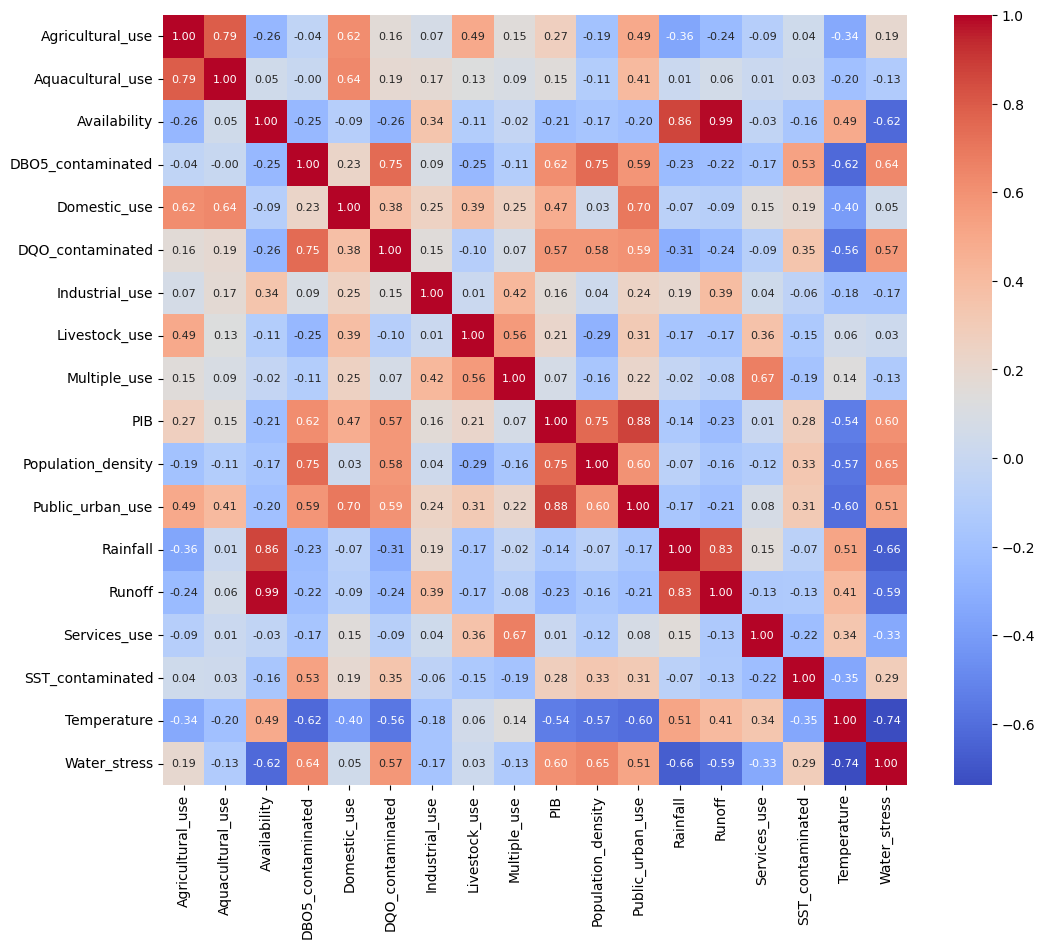

In [3]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", annot_kws={"size": 8}, fmt=".2f")
plt.show()

## Data preparation

Some columns are excluded based on a threshold of 0.75 and domain knowledge

In [4]:
columns_to_remove = [
    "RHA_Year",
    "DBO5_contaminated",
    "Rainfall",
    "PIB",
    "Runoff",
    "Aquacultural_use",
]
data_reduced = data.drop(columns=columns_to_remove)

In [5]:
X = data_reduced.drop("Water_stress", axis=1)
y = data_reduced["Water_stress"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [6]:
print(X_train.shape, y_train.shape)

(175, 12) (175,)


Scaling variables

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling

Three models for the analysis

In [8]:
lasso_model = Lasso(random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)

Cross Validation (5 folds)

In [9]:
lasso_cv_scores = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5)
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
xgb_cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5)
print("LASSO CV Scores:", lasso_cv_scores)
print("Random Forest CV Scores:", rf_cv_scores)
print("XGBoost CV Scores:", xgb_cv_scores)

LASSO CV Scores: [0.8825326  0.89567164 0.89831186 0.78724747 0.90308207]
Random Forest CV Scores: [0.9943224  0.9852213  0.99221901 0.99083156 0.94975105]
XGBoost CV Scores: [0.98717474 0.98695424 0.99724802 0.99096418 0.9549033 ]


In [10]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

In [11]:
lasso_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Model evaluation

In [12]:
mse_lasso, mae_lasso, r2_lasso = evaluate_model(lasso_model, X_test_scaled, y_test)
mse_rf, mae_rf, r2_rf = evaluate_model(rf_model, X_test, y_test)
mse_xgb, mae_xgb, r2_xgb = evaluate_model(xgb_model, X_test, y_test)

print(f"LASSO - Test MSE: {mse_lasso}, MAE: {mae_lasso}, R2: {r2_lasso}")
print(f"Random Forest - Test MSE: {mse_rf}, MAE: {mae_rf}, R2: {r2_rf}")
print(f"XGBoost - Test MSE: {mse_xgb}, MAE: {mae_xgb}, R2: {r2_xgb}")

LASSO - Test MSE: 164.37597658969412, MAE: 10.970548307323401, R2: 0.8576090969642556
Random Forest - Test MSE: 1.3450148729466598, MAE: 0.8844168953754732, R2: 0.9988348791208497
XGBoost - Test MSE: 22.026131540621197, MAE: 1.520782967090607, R2: 0.9809198349690609


LASSO Coefficients

In [13]:
lasso_coefficients = lasso_model.coef_
print("LASSO Coefficients:")
for feature, coef in zip(X_train.columns, lasso_coefficients):
    print(f"{feature}: {coef}")

LASSO Coefficients:
Agricultural_use: 0.0
Availability: -10.670685818456615
Domestic_use: -13.404563220454506
DQO_contaminated: 6.8330815726364795
Industrial_use: -4.924672528794739
Livestock_use: 6.499958896117408
Multiple_use: 1.5572096006920904
Population_density: 7.031645368879797
Public_urban_use: 9.703378535704443
Services_use: -8.149794059382447
SST_contaminated: -0.029183532732025372
Temperature: -12.821705793817506


LASSO
1. Domestic_use
2. Temperature
3. Availability
4. Public_urban_use
5. Services_use
6. Population_density

## Variable importance with Shapley values

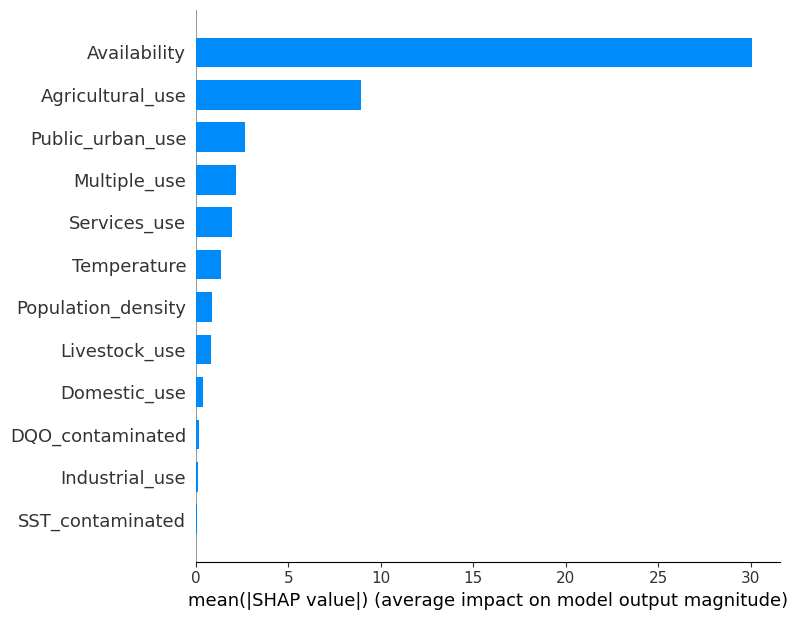

In [14]:
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_train)
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

[23:05:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


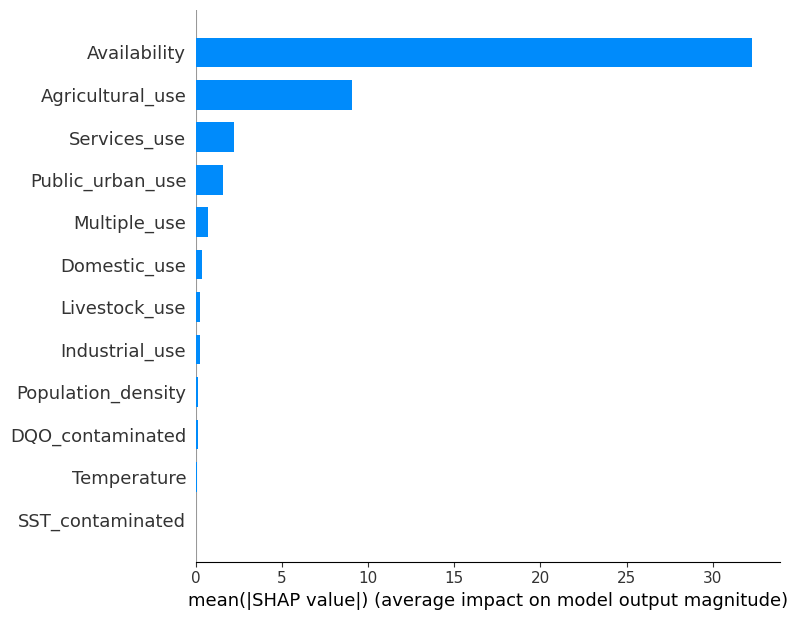

In [15]:
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_train)
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")

## Selection
* Availability
* Agricultural_use
* Public_urban_use
* Services_use
* Temperature
* Domestic_use

## Modeling with selected features

In [16]:
X = data_reduced[
    [
        "Availability",
        "Agricultural_use",
        "Public_urban_use",
        "Services_use",
        "Temperature",
        "Domestic_use",
    ]
]
y = data_reduced["Water_stress"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [17]:
print(X_train.shape, y_train.shape)

(175, 6) (175,)


In [18]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb_cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5)
print("XGBoost CV Scores:", xgb_cv_scores)

XGBoost CV Scores: [0.98717474 0.98695424 0.99724802 0.99096418 0.9549033 ]


In [19]:
xgb_model.fit(X_train, y_train)
print(f"XGBoost - Test MSE: {mse_xgb}, MAE: {mae_xgb}, R2: {r2_xgb}")

XGBoost - Test MSE: 22.026131540621197, MAE: 1.520782967090607, R2: 0.9809198349690609


In [20]:
xgb_model.save_model("./../Models/water_stress_predictor.json")